In [1]:
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
import torch.nn.init as init

from modules.utils import FeedForwardNetwork, clear_temp
from modules.training import train
from modules.problems import GrayScott

import scienceplots
plt.style.use(['science'])
mpl.rcParams["font.size"] = "12"

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
def set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled):
    
    def nearest_index(array, values):
            values = [np.abs(array - v).argmin().item() for v in values.detach().numpy()]
            return values
    
    t = torch.linspace(0, problem.T, problem.Nt)
    x = torch.linspace(problem.L, problem.R, problem.Nx)
    problem.left_values =  problem.left_boundary [nearest_index(t, t_left_sampled) ].to(device)
    problem.right_values = problem.right_boundary[nearest_index(t, t_right_sampled)].to(device)
    problem.init_values =  problem.initial_values[nearest_index(x, x_sampled)      ].to(device)

def grid_sample(problem, N_I, N_L, N_R, N_F, loss_history=None):
    
    t_sampled = torch.linspace(0, problem.T, len(problem.solution[0]))
    
    x_sampled = torch.linspace(problem.L, problem.R, N_I, requires_grad=True)
    t_left_sampled =  torch.linspace(0, problem.T, N_L, requires_grad=True)
    t_right_sampled = torch.linspace(0, problem.T, N_R, requires_grad=True)
    
    k = np.sqrt(problem.Nt * problem.Nx / N_F)
    nt, nx = int(problem.Nt / k), int(problem.Nx / k)
    x_pts, t_pts = [
        pts.reshape(-1, 1) for pts in torch.meshgrid(
        torch.linspace(problem.L, problem.R, nx, requires_grad=True).to(device),
        torch.linspace(0, problem.T, nt, requires_grad=True).to(device),
        indexing='ij'
    )]
    
    set_boundary_values(problem, x_sampled, t_left_sampled, t_right_sampled)
        
    return (x_sampled.to(device), t_left_sampled.to(device), t_right_sampled.to(device)), (x_pts.to(device), t_pts.to(device))

In [1]:
problem_number = 4
problem = GrayScott.get_problem(problem_number)
name = f'gs{problem_number}'

NameError: name 'GrayScott' is not defined

In [ ]:
problem_number = 4
problem = GrayScott.get_problem(problem_number)
name = f'gs{problem_number}'

model = FeedForwardNetwork(4, 48, output_dim=2)
# model.init_weights(init.eye_)

num_iters = 5000
plot_every = 250

train(
    problem,
    model,
    hyperparameters={
        'optimizer': torch.optim.Adam,
        'arguments': {"lr": 1e-2},
        'num_iters': num_iters,
        'collocation_points': {
            'sample_every': 0,
            'N_points': {'N_F': 2048},
            'generation_function': f
        },
        'coefs': [0.2, 0.8]
    },
    plotting_params={
        'save_dir': './.temp/',
        'plot_every': plot_every,
        'size': (5, 3)
    },
    name=name,
    print_every=1500
)

print('Creating gif...')
create_gif(
    images=[f'./.temp/{name}_iteration_{i}.jpg' for i in range(0, num_iters, plot_every)], 
    path=f'../images/animations/{name}_test_learning.gif'
)

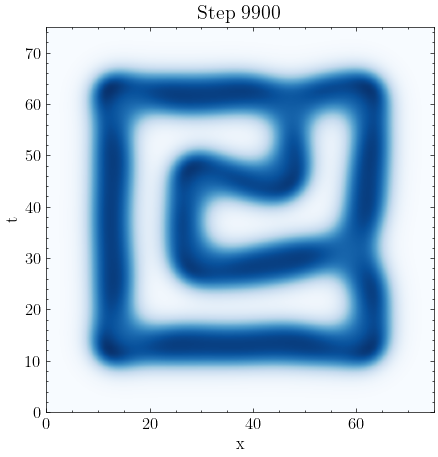

In [61]:
problem.save_animation('../images/animations/gs_test.gif', size=(5, 5), step=100, fps=30)